Group Name: AG xx.

Student Name (Student ID):

1. Wong Ji Fong (A0249572U)

2. xxxx xxxxx (xxxxxxx)

3. xxxx xxxxx (xxxxxxx)

In [1]:
# Type hinting is used within this document to help understand parameters
# Required, type hints refer to self:
from __future__ import annotations
# Assistive imports
from collections import namedtuple
from typing import Tuple, List, Optional, Set, Union, Generator
from heapq import heappush, heappop
from collections import deque
from functools import partial

# Question 1

Consider the maze shown below. The Maze has 16 rows and 24 columns The objective is to find a shortest path from cell $S$ to cell $G$.


![Maze](Maze_Assignment_1-1.jpg)


The agent can take four actions in each cell: 'RIGHT', 'DOWN', 'UP', 'LEFT'.  

Each cell is represented as $(x,y)$, where $x$ indicates row number and $y$ indicates column number. Action 'UP' takes the agent from cell $(x,y)$ to $(x+1,y)$. Action 'DOWN' takes the agent from cell $(x,y)$ to $(x-1,y)$. Action 'RIGHT' takes the agent from cell $(x,y)$ to $(x,y+1)$. Action 'LEFT' takes the agent from cell $(x,y)$ to $(x,y-1)$. The triplet $(s,a,s')$  indicates that taking action $a$ at state $s$ leads to state $s'$. Actions 'LEFT' or 'RIGHT' cost 10 units for all $(s,a,s')$. Actions 'UP' or 'DOWN' cost 1 unit for all  $(s,a,s')$.  The agent cannot move into cells that are shaded. Assume that the agent knows the boundaries of the maze and has full observability. Consequently, at the bottom (row 0) and top (row 15), the agent will not take actions 'DOWN' and 'UP', respectively; at left (column 0) and right (column 23) columns, the agent will not take 'LEFT' and 'RIGHT' actions, respectively. Similalry, the agent will not take actions that lead to shaded region in the maze.

## **Q1.a: Class Maze(Problem)** [3 Marks]

Write a Maze class to create a model for this problem. You should not use an explicit state space model. The modelling should inherit the abstract class 'Problem' (given below). With the problem formulation, find the shortest path from S to G cell. Propose and implement multiple heuristics (at least two heuristics) for informed search algorithms. 

## **Q1.b: Analysis of the Algorithms** [7 Marks]

1. Solve the above Maze problem using the following algorithms

    a. Breadth-First Search 

    b. Depth-First Search with Cycle-Check

    c. Iterative-Deepening Search with Cycle-Check

    d. Uniform-Cost Search

    e. A* Search 

    f. Greedy Best-first Search

    g. Any other variants for search algorithms that are not discussed in the class (bonus/optional question) 

2. Identify the number of nodes generated, number of nodes expanded, maximum frontier size, and path-cost for the above algorithms. 
 
3. Compare the performance of informed search algorithms with proposed heuristics. Identify the best performing heuristic and explain.
 
4. Draw a bar plot comparing the statistics of the algorithms and explain the results. 

Note 1: You must follow the problem formulation discussed in the class. A abstract class for Problem amd Node definition is presented below. The search tree generation should follow the template discussed in the class (i.e., Node class, expand methods, etc.). 

Note 2: If you are borrowing a block of code (for example, helper functions or data structures, etc.) from AIMA4e repository, you have to acknowledge it in the code. 

Note 3: The code should be written in a single jupyter notebook file.

In [2]:
class Problem:
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    The default heuristic is 0 and the default action cost is 1 for all states.
    When you create an instance of a subclass, specify `initial`, and `goal` states 
    (or give an `is_goal` method) and perhaps other keyword args for the subclass."""

    def __init__(self, initial=None, goal=None, **kwds): 
        self.__dict__.update(initial=initial, goal=goal, **kwds)
        
    def actions(self, state):        raise NotImplementedError
    def result(self, state, action): raise NotImplementedError
    def is_goal(self, state):        return state == self.goal
    def action_cost(self, s, a, s1): return 1
    def h(self, node):               return 0
    
    def __str__(self):
        return '{}({!r}, {!r})'.format(
            type(self).__name__, self.initial, self.goal)

In [3]:
# Use the following Node class to generate search tree
import math
# Defining a named tuple called state for readability
# immutability and ephemeral use:
NewState = namedtuple('NewState', ['cost', 'coordinates', 'action'])

class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.__dict__.update(state=state, parent=parent, action=action, path_cost=path_cost)

    
    def __len__(self): return 0 if self.parent is None else (1 + len(self.parent))
    def __lt__(self, other): return self.path_cost < other.path_cost 
    
    # newly defined to assist with trace, and repr redefined
    # for readability
    def __repr__(self): 
        return '<state:(x:{},y:{}) path_cost:{} action:{}>'\
                .format(self.state[0], self.state[1], self.path_cost, self.action)
    
    def __eq__(self, other: Node): 
        return (self.state == other.state and self.path_cost == other.path_cost)
    
    def expand_node(self, state: NewState):
        expanded_node = Node(state.coordinates)
        expanded_node.parent = self
        expanded_node.path_cost = self.path_cost + state.cost
        expanded_node.action = state.action
        return expanded_node
    
    def expand(self, permissable_actions: List[NewState]):
        """
        Args:
            permissable_actions (List[NewState]):
                List of possible actions to take
        """
        return list(map(self.expand_node, permissable_actions))
    
    def __bool__(self):
        return True if self.state else False
    
    def __hash__(self):
        # for in set lookup for `visited`
        return hash(self.state)

In [4]:
class Maze(Problem):
    def __init__(self,
                 initial: Node,
                 goal: Node,
                 boundaries: Tuple[int, int],
                 action_cost_map: Optional[dict],
                 **kwds):
        """
        Add type hints and parameter to know boundaries
        given the assumption "Assume that the agent knows
        the boundaries of the maze and has full observability"
        
        Args:
            initial (Node): Node for the initial state
            goal (Node): Node for the goal state
            boundaries (Tuple[int,int]):
                (rows, cols) of boundaries, assuming (0,0) to (rows,cols) 
                as problem space
        """
        super().__init__(initial=initial,
                         goal=goal,
                         boundaries=boundaries,
                         action_cost_map=action_cost_map,
                         **kwds)
    
    def action_cost(self, node: Node, action: str) -> int:
        """
        Args:
            node (Node): Current node state
            action (str): Action to take
        
        Returns:
            int: Cost (s, a, s')
        """
        return self.action_cost_map[action]
    
    def _transform_permissable_action(self,
                                      actions: Tuple[Tuple[int, int], str],
                                      node: Node) -> Node:
        state, action = actions
        action_cost = self.action_cost(node, action)
        return NewState(action_cost, state, action)
        
    def actions(self, node: Node) -> List[Tuple[str, int]]:
        """
        Return permissable actions as list of actions
        as (COST, s', ACTION)
        Args:
            state (Node): Agents current state node
        
        Returns:
            List[Node]:
                List of permissable nodes
        """
        x = node.state[0]
        y = node.state[1]
        parent = node.parent.state if node.parent else None
        
        permissable_x_y = {((x+1, y), 'UP'),
                           ((x-1, y), 'DOWN'),
                           ((x, y+1), 'RIGHT'),
                           ((x, y-1), 'LEFT')}
        
        return list(
                    map(
                        lambda actions: self._transform_permissable_action(actions, node),
                        filter(
                                lambda actions:
                                   # Ensuring they permissable actions are:
                                   # * within boundaries
                                   # * not a shaded region
                                   0<=actions[0][0]<self.boundaries[0] and
                                   0<=actions[0][1]<self.boundaries[1] and
                                   (actions[0][0], actions[0][1]) not in self.shaded_regions,
                               permissable_x_y
                        )
                )
           )
    
    def h(self, node: Node) -> Union[float, int]:
        """
        Implementing Manhatten distance
        Args:
            node (Node): Current agent node
        
        Returns:
            Union[float, int]: heuristic value
        """
        return abs(self.goal.state[0]-node.state[0]) +\
                abs(self.goal.state[1]-node.state[1])
    
    def h2(self, node: Node) -> Union[float, int]:
        """
        Implementing Euclidean distance
        Args:
            node (Node): Current agent node
        
        Returns:
            Union[float, int]: heuristic value
        """
        return ((self.goal.state[0]-node.state[0])**2 + 
                (self.goal.state[1]-node.state[1])**2)**(1/2)
        
        
    def __repr__(self):
        return '{}({!r}, {!r})'.format(
            type(self).__name__, self.initial, self.goal)
    
    def is_goal(self, node):
        return node.state == self.goal.state

### Instantiating start and goal nodes

In [5]:
start_node = Node((8,10))
goal_node = Node((11,9))

In [6]:
start_node

<state:(x:8,y:10) path_cost:0 action:None>

### Instantiating maze with start, end, maze size, boundaries, action costs and shaded regions (not known to agent itself)

In [7]:
maze = Maze(start_node,
            goal_node,
            boundaries=(16, 24),
            action_cost_map={'LEFT':10, 'RIGHT': 10, 'UP': 1, 'DOWN': 1},
            shaded_regions = {(7, 9),
                              (6, 9),
                              (10, 12),
                              (10, 13),
                              (11, 12),
                              (10, 9),
                              (12, 10),
                              (9, 9),
                              (13, 10),
                              (8, 9),
                              (11, 13),
                              (10, 10),
                              (14, 9),
                              (11, 10)})

### Example path to show permissable actions taking into account restrictions

In [8]:
node_1 = Node((0,0))

In [9]:
# List of permissable actions. From 0,0, agent can only move up and right.
actions = maze.actions(node_1)
actions

[NewState(cost=10, coordinates=(0, 1), action='RIGHT'),
 NewState(cost=1, coordinates=(1, 0), action='UP')]

In [10]:
# Taking the right
expanded_node_1 = node_1.expand(actions)[0] # picking a child to then expand
expanded_node_1

<state:(x:0,y:1) path_cost:10 action:RIGHT>

In [11]:
actions_2 = maze.actions(expanded_node_1)
actions_2

[NewState(cost=10, coordinates=(0, 0), action='LEFT'),
 NewState(cost=1, coordinates=(1, 1), action='UP'),
 NewState(cost=10, coordinates=(0, 2), action='RIGHT')]

In [12]:
expanded_node_2 = expanded_node_1.expand(actions_2)[0]

In [13]:
expanded_node_2

<state:(x:0,y:0) path_cost:20 action:LEFT>

In [14]:
def trace_all_actions_taken(state: Node) -> List[str]:
    """
    Return path taken given node
    Args:
        state (Node): Node of a path
    
    Returns:
        List[str]:
            Actions taken in order from start
    """
    all_actions = []
    while state.action != None:
        all_actions.append(state.action)
        state = state.parent
    return all_actions[::-1] # reverse it back

In [15]:
trace_all_actions_taken(expanded_node_2)

['RIGHT', 'LEFT']

In [16]:
# Example of where agent will only be able to choose
# up/down due to shaded areas
maze.actions(Node((10,11)))

[NewState(cost=1, coordinates=(9, 11), action='DOWN'),
 NewState(cost=1, coordinates=(11, 11), action='UP')]

### Per the comparison dunder method defined, comparing the nodes so far yields that node_2 has a higher pathcost than node_1

In [17]:
expanded_node_2 < expanded_node_1

False

### Test Search

In [18]:
def bfs_search(maze: Maze) -> (Node, set):
    """
    Args:
        maze (Maze): Maze class to run the search on
    
    Returns:
        solution (Node):
            Node for which the solution was found
        visited (set):
            Set for which was visited
    """
    initial_node = maze.initial
    frontier = deque([initial_node])
    visited = set()
    while frontier:
        frontier_node = frontier.popleft()
        actions = maze.actions(frontier_node)
        for child in frontier_node.expand(actions):
            if maze.is_goal(child):
                return child, visited
            if child not in visited:
                visited.add(child)
                frontier.append(child)
    raise Exception('Unable to find target')

In [19]:
child, visited = bfs_search(maze)

In [20]:
print(f"Nodes explored: {len(visited)}")

Nodes explored: 1123


In [21]:
def informed_search(
        maze: Maze,
        f: Callable
    ) -> (Node, set):
    """
    Args:
        maze (Maze): Maze to run search on
        f (Callable)
    
    Returns:
        child (Node): Solution node
        visited (set): Visited set
    """
    initial_node = maze.initial
    
    frontier = [(f(initial_node), initial_node)]
    visited = {maze.initial.state: maze.initial}
    
    expanded = [] # remove
    
    while frontier:
        heuristic, frontier_node = heappop(frontier)        
        actions = maze.actions(frontier_node)
        if maze.is_goal(frontier_node):
            return frontier_node, expanded # expanded
        
        for child in frontier_node.expand(actions):
            expanded.append((child.state, 'expand'))
            if child.state not in visited or child.path_cost < visited[child.state].path_cost:
                visited[child.state] = child
                heappush(frontier, (f(child), child))
    raise Exception('Unable to find target')

In [22]:
def greedy_best_first_search(
        maze: Maze,
        h:Literal['h', 'h2']
    ) -> (Node, set):
    """
    Args:
        maze (Maze): Maze to run search on
        h (Literal['h', 'h2']):
            h for Manhatten distance
            h2 for Euclidean distance
    
    Returns:
        child (Node): Solution node
        visited (set): Visited set
    """
    initial_node = maze.initial
    h = getattr(maze, h)
    
    frontier = [(h(initial_node), initial_node)]
    visited = set()
    
    while frontier:
        heuristic, frontier_node = heappop(frontier)
        
        print(f'Heuristic value: {heuristic} Coord:{frontier_node.state}')
        
        actions = maze.actions(frontier_node)
        for child in frontier_node.expand(actions):
            if child.state not in visited:
                if maze.is_goal(child):
                    return child, visited
                else:
                    visited.add(child.state)
                    heappush(frontier, (h(child), child))
    raise Exception('Unable to find target')

In [23]:
child, visited = greedy_best_first_search(maze, 'h')
print(f"Nodes explored: {len(visited)}")

Heuristic value: 4 Coord:(8, 10)
Heuristic value: 3 Coord:(9, 10)
Heuristic value: 4 Coord:(8, 10)
Heuristic value: 4 Coord:(9, 11)
Heuristic value: 3 Coord:(10, 11)
Heuristic value: 2 Coord:(11, 11)
Heuristic value: 3 Coord:(12, 11)
Heuristic value: 4 Coord:(13, 11)
Heuristic value: 4 Coord:(12, 12)
Heuristic value: 5 Coord:(7, 10)
Heuristic value: 5 Coord:(8, 11)
Heuristic value: 5 Coord:(14, 11)
Heuristic value: 4 Coord:(14, 10)
Heuristic value: 5 Coord:(9, 12)
Heuristic value: 5 Coord:(13, 12)
Heuristic value: 5 Coord:(15, 10)
Heuristic value: 4 Coord:(15, 9)
Heuristic value: 5 Coord:(12, 13)
Heuristic value: 5 Coord:(15, 8)
Heuristic value: 4 Coord:(14, 8)
Heuristic value: 3 Coord:(13, 8)
Heuristic value: 2 Coord:(12, 8)
Heuristic value: 1 Coord:(11, 8)
Nodes explored: 37


### Fun stuff

In [24]:
# %matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib import colors

import matplotlib.animation as animation

In [25]:
def plot_state(draw_maze, 
               coord:Tuple[int, int],
               marker_type:Literal['start', 'end', 'path', 'expand', 'barrier']):
    mapping = {
        'start': 10,
        'end': 20,
        'expand': 30,
        'path': 40,
        'barrier': 50,
        'replace': 60
    }
    draw_maze[-(coord[0]+1)][coord[1]] = mapping[marker_type]
    return draw_maze

def init_maze(maze):
    cols = maze.boundaries[1]
    rows = maze.boundaries[0]
    draw_maze = [[0 for j in range(cols)]
                     for i in range(rows)]
    
    draw_maze = plot_state(draw_maze, maze.initial.state, 'start')
    draw_maze = plot_state(draw_maze, maze.goal.state, 'end')
    
    for barrier in maze.shaded_regions:
        draw_maze = plot_state(draw_maze, barrier, 'barrier')
    
    return draw_maze

In [26]:
def bfs_search_animated(maze: Maze):
    initial_node = maze.initial
    frontier = deque([initial_node])
    visited = set([initial_node.state])
    
    expanded = []
    while frontier:
        frontier_node = frontier.popleft()
        actions = maze.actions(frontier_node)
        for child in frontier_node.expand(actions):
            # for animation
            expanded.append((child.state, 'expand'))
            
            if maze.is_goal(child):
                return child, expanded
            if child.state not in visited:
                visited.add(child.state)
                frontier.append(child)
    raise Exception("Solution not found")

In [27]:
# def greedy_best_first_search_animated(maze: Maze, h:Literal['h', 'h2']):
#     initial_node = maze.initial
#     h = getattr(maze, h)
    
#     frontier = [(h(initial_node), initial_node)]
#     visited = set()
#     expanded = []
    
#     while frontier:
#         heuristic, frontier_node = heappop(frontier)
        
#         print(f'{(heuristic, frontier_node.state)}')
        
#         actions = maze.actions(frontier_node)
#         for child in frontier_node.expand(actions):
#             expanded.append((child.state, 'expand'))
#             if child not in visited:
#                 if maze.is_goal(child):
#                     return child, expanded
#                 else:
#                     visited.add(child)
#                     heappush(frontier, (h(child), child))
#     raise Exception('Unable to find target')

In [28]:
def trace_all_states_taken(state: Node) -> List[str]:
    """
    Return path taken given node
    Args:
        state (Node): Node of a path
    
    Returns:
        List[str]:
            Actions taken in order from start
    """
    all_actions = []
    while state.action != None:
        all_actions.append((state.state, 'path'))
        state = state.parent
    return all_actions

In [29]:
def get_expanded_from_algo(
        maze: Maze,
        algo_func: Callable
    ) -> List[Node]:
    """
    Helper function to create the expand list
    Args:
        maze (Maze): Maze instance
        algo_func (Callable): Algo to run
    """
    algo_goal, algo_expanded = algo_func(maze)
    algo_expanded.extend(trace_all_states_taken(algo_goal))
    return algo_expanded

In [30]:
from IPython.display import Video

def animate_algo(maze, 
                 expanded: List[Tuple[int,int], str], 
                 filename:str) -> str:
    """
    Args:
        expanded (List[Tuple[int,int], str):
            List of coordinate pairs and markers to display
        filename (str):
            Filename to save the video file of the algo as
    
    Returns:
        str: filename to play using IPython.display.Video
    """
    maze_map = init_maze(maze)

    def tick_range(n):
        value = -0.5
        arr = [value]
        while value < n-1:
            value += 1
            arr.append(value)
        return arr
    
    fig, ax = plt.subplots()
    cmap = colors.ListedColormap(
            ['white','green','red','blue', 'green', 'black', 'grey']
    )
    bounds = [0,10,20,30,40,50,60,70]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    data = ax.imshow(maze_map, cmap=cmap, norm=norm)
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    rows=maze.boundaries[0]
    cols=maze.boundaries[1]
    col_ticks = tick_range(cols)
    row_ticks = tick_range(rows)
    ax.set_xticks(col_ticks)
    ax.set_yticks(row_ticks)
    ax.set_xticklabels(list(map(lambda x: int(x+0.5), col_ticks)))
    ax.set_yticklabels(list(map(lambda x: int(x+0.5), row_ticks[::-1])))
    
    def animate_func(i, maze_map):
        maze_map = plot_state(maze_map,
                              expanded[i][0],
                              expanded[i][1])
        data.set_data(maze_map)
        return [data]

    anim = animation.FuncAnimation(fig, 
                                   animate_func,
                                   frames=len(expanded),
                                   interval=30,
                                   fargs=(maze_map,),
                                   repeat=False)
    anim.save(filename, writer='ffmpeg') # to save
    return filename

In [31]:
def save_and_view_visualisation(
        algo: Literal['Breadth first search',
                      'Greedy best first search']
    ) -> Video:
    if algo not in ALGO_MAP:
        raise Exception('Please provide a corresponding algo name')
    expanded = get_expanded_from_algo(maze, ALGO_MAP[algo])
    return Video(animate_algo(maze, expanded, f'{algo}.mp4'))

Replaced (12, 8) 327 347
Replaced (12, 9) 337 357
Replaced (12, 7) 337 357
Replaced (12, 8) 327 347
Replaced (12, 9) 337 357
Replaced (12, 7) 337 357


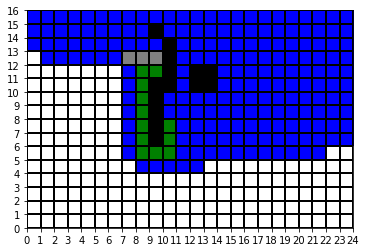

In [32]:
# Testing replacement on lower path cost found
maze = Maze(start_node,
            goal_node,
            boundaries=(16, 24),
            action_cost_map={
                             'LEFT':10,
                             'RIGHT': 10,
                             'UP': 1,
                             'DOWN': 100 # Expensive action
                            },
            shaded_regions = {(7, 9),
                              (6, 9),
                              (10, 12),
                              (10, 13),
                              (11, 12),
                              (10, 9),
                              (12, 10),
                              (9, 9),
                              (13, 10),
                              (8, 9),
                              (11, 13),
                              (10, 10),
                              (14, 9),
                              (11, 10)})

def informed_search(
        maze: Maze,
        f: Callable
    ) -> (Node, set):
    """
    Args:
        maze (Maze): Maze to run search on
        f (Callable)
    
    Returns:
        child (Node): Solution node
        visited (set): Visited set
    """
    initial_node = maze.initial
    
    frontier = [(f(initial_node), initial_node)]
    visited = {maze.initial.state: maze.initial}
    
    expanded = [] # remove
    
    while frontier:
        heuristic, frontier_node = heappop(frontier)
        
        actions = maze.actions(frontier_node)
        if maze.is_goal(frontier_node):
            return frontier_node, expanded
        
        for child in frontier_node.expand(actions):
            expanded.append((child.state, 'expand'))
            if child.state not in visited or child.path_cost < visited[child.state].path_cost:
                if child.state in visited:
                    if child.path_cost < visited[child.state].path_cost:
                        print('Replaced', child.state, child.path_cost, visited[child.state].path_cost)
                        expanded.append((child.state, 'replace'))
                visited[child.state] = child
                heappush(frontier, (f(child), child))
    raise Exception('Unable to find target')

import random
def h(action):
    if action == 'DOWN':
        return -5
    return 10

child, expanded = informed_search(maze, lambda node: node.path_cost + h(node.action))
informed_search_partial = partial(informed_search, f=lambda node: node.path_cost + maze.h(node))
Video(animate_algo(maze, get_expanded_from_algo(maze, informed_search_partial), filename='replacement.mp4'))

In [ ]:
ALGO_MAP = {
    'Breadth first search': bfs_search_animated,
    'Greedy best first search h': partial(informed_search, f=lambda node: maze.h(node)),
    'Greedy best first search h2': partial(informed_search, f=lambda node: maze.h2(node)),
    'UCS': partial(informed_search, f=lambda node: node.path_cost + 0),
    'A* h': partial(informed_search, f=lambda node: node.path_cost + maze.h(node)),
    'A* h2': partial(informed_search, f=lambda node: node.path_cost + maze.h2(node))
}
save_and_view_visualisation('Breadth first search')

### Heuristics 1 and 2
Defining an arbitrary node

In [ ]:
intermediate_node = Node((9,10))

In [ ]:
print(f"Manhatten distance: {maze.h(intermediate_node)}")
print(f"Euclidean distance: {maze.h2(intermediate_node)}")

In [ ]:
# Tests, please ignore but use for testing classes
print(start_node == Node((8,10)))
print(goal_node == Node((11, 9)))